<a href="https://colab.research.google.com/github/janchorowski/ml_uwr/blob/fall2020/lectures/14_pgm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning @ UWr 2020

**Lecture 14**
$\def\R{{\mathbb R}} \def\i{^{(i)}} \def\sjt{\mathrm{s.t. }\ }
\def\indep{\perp} \def\nindep{\not\perp} \def\N{\mathcal{N}}$

In this lecture we will learn the basics of Probabilistic Graphical Models (PGMs): a way of graphically specifying complex probability distributions which help us to reason about them. We will than use PGMs to see how we can apply Machine Learning to sequential data using Kalman Filters and Hidden Markov Models.

## PGM Intuitions

Consider the case of 3 random variables, $X$, $Y$, and $Z$. Their joint probability distribution can be factorized as:

$$
p(X,Y,Z) = p(X)p(Y|X)p(Z|X,Y)
$$

We can picture this factorization using a graph in which the nodes are the variables, and the directed edges denote conditional dependencies. Of course, the PGM can not contain cycles (it is by definition a DAG):

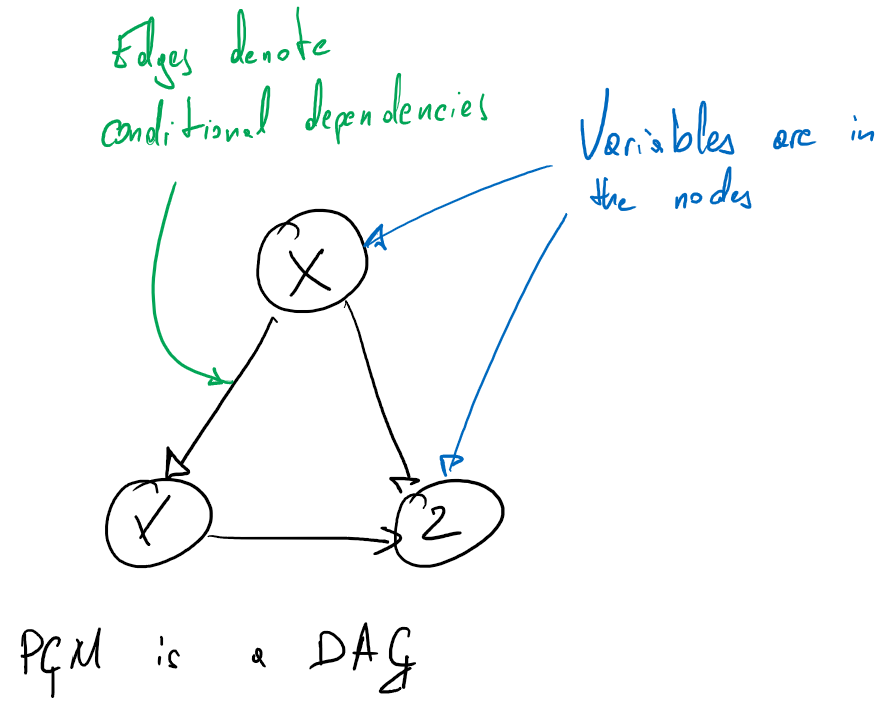

### What are PGMs good for?

The main benefit of PGMs is that we can reason about various models, and their underlying probability distributions using the same set of tools and techniques. In particular PGMs offer:
- visual and intuitive techniques to reason about independencies
- generic inference (i.e. getting the distribution in one node conditioned on other nodes) algorithms, both exact and approximate. [Sadly, they are outside the scope of this course].

## PGM Examples

Let's construct a few PGMs for some models that we already know. First, consider the following PGM. Can you guess which model (that you already know) it is?

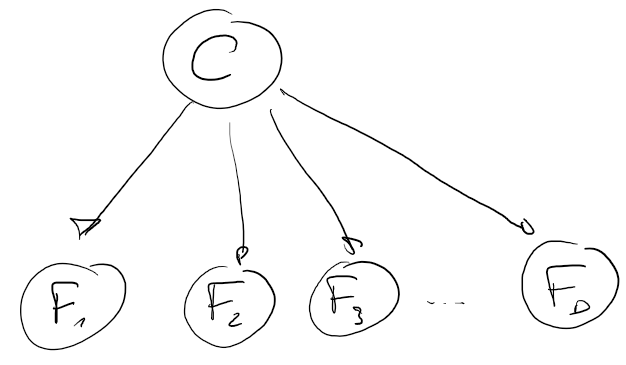

Can you see that the above PGM corresponds to a NaiveBayes model? 

Notice, that the PGM specifies a factorization which implies that features are independent given the class label. In fact, the PGM means that the assumed probability distribution factorizes as:

$$
p(C, F_1, F_2, ..., F_n) = p(C)p(F_1|c)p(F_2|c)... p(F_n|c)
$$

## Reasoning about independences in PGMs

As we have seen in the Naive Bayes example, PGMs allow us to directly see dependencies and independencies of an assumed probability distribution.

Let's walk over a few cases and see which nodes are conditionally dependent or independent.

Through the examples we will use distributions over three variables: $A$, $B$, and $C$. However, the general rules of reasoning about dependencies will generalize to larger diagrams as well.

Recall that two variables $A$ and $B$ are inconditionally independent, which we will denote $A \indep B | \emptyset$ iff $p(A,B) = p(A)p(B)$.

Likewise two variables $A$ and $B$ are independent given $C$, denoted as $A\indep B | C$ iff $p(A,B|C) = p(A|C)p(B|C)$.

Finally, we will use $\nindep$ to denote that two variables may be dependent (i.e. we have not proven that they are independent). 

### 'Naive' structure (tail-tail)

Consider the following PGM

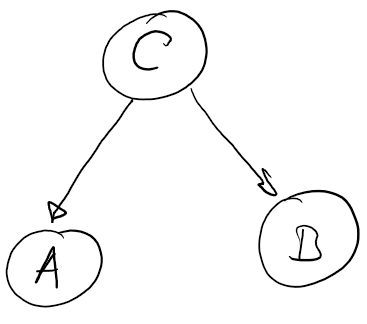

The edges in the PGM directly encode that $A$ depends on $C$ and that $B$ depends on $C$:

$$
p(A,B,C) = p(C)p(A|C)p(B|C)
$$

Now let's prove, from definition that in this PGM $A\indep B | C$:

$$
p(A,B|C) = \frac{p(A,B,C)}{p(C)} = \frac{p(C)p(A|C)p(B|C)}{p(C)} = p(A|C)p(B|C)
$$

However, we can't show that $A\indep B | \emptyset$:
$$
p(A,B) = \sum_C p(A,B,C) = \sum_C p(C)p(A|C)p(B|C)
$$

In fact, it is easy to show that inconditionally, $A$ depends on $B$: suppose, that $A$ and $B$ are fully specified given $C$. Then knowing $A$, gives us a good guess about $C$, which in turn specifies $B$!

### Chain (head-tail)

Now consider the PGM which factorizes as

$$
p(A,B,C) = p(A)P(C|A)P(B|C)
$$


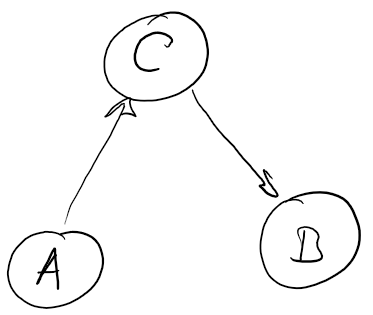

It is the naive model, with one edge flipped.

What independencies can be inferred in this diagram?

Quite intuitively, $A\nindep B | \emptyset$: knowing $A$ gives us an idea about $C$, which in turn informs us on $B$.

However, is it the case that $A \indep B | C$?

Again, let's analyze it using the basic rules of probability:

$$
p(A,B|C) = \frac{p(A,B,C)}{p(C)} = \frac{p(A)p(C|A)p(B|C)}{p(C)} = p(A|C)p(B|C),
$$
where we have used the Bayes theorem $\frac{p(A)p(C|A)}{p(C)}=p(A|C)$.

We see that the chain diagram and the naive diagram imply the same independencies!

### V-structures (head-head)

The following PGM has surprisingly different properties

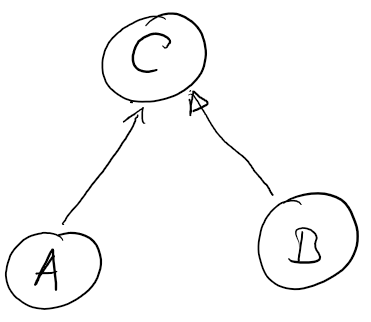

The implied probability distribution is 

$$
p(A,B,C) = p(A)p(B)p(C|A,B)
$$

Now we can observe that:

$$
p(A,B) = \sum_C p(A,B,C) = \sum_C p(A)p(B)p(C|A,B) = p(A)p(B) \sum_C p(C|A,B) = p(A)p(B)
$$

This is visible from the PGM: nodes $A$ and $B$ have no dependencies.

However, are $A$ and $B$ still independent given $C$? Formally, is it true that $A\indep B | C$?

We can't prove this independence:

$$
p(A,B|C) = \frac{p(A)p(B)p(C|A,B)}{p(C)}
$$

doesn't simplify.

In fact, we can show that $A$ and $B$ are dependent given $C$. Suppose that all variables are binary and that $C=A XOR B$. Now it is visible that $B$ is known given both $A$ and $C$!

This phenomenon is known as _"explaining away"_: if an event can be triggered by either of a number of unlikely causes, knowing that one of the possible causes has happend together with the event makes the other causes less probable.

As a concrete use case, consider the following example: there is a fuel gauge, which requires a battery to function. Thus it can show an "empty" readout in two cases there is no fuel, or the battery is dead.

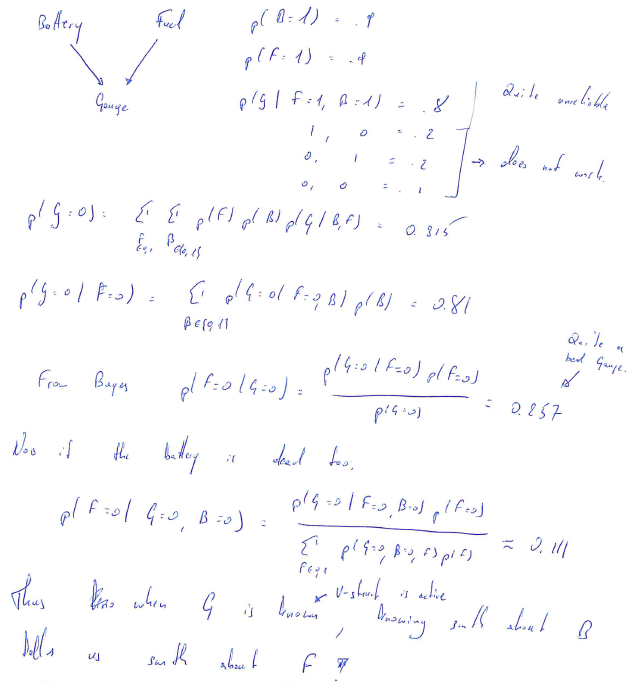

## D-separation

D-separation is a formalization of the above observations on conditional independencies.

Consider three non-intersecting _sets_ of random variables (i.e. nodes in the graph) $\mathbb{A}$, $\mathbb{B}$, and $\mathbb{C}$. 

Now consider a path, connecting a node $A\in\mathbb{A}$ to $B\in\mathbb{B}$ which ignores the direction of edges. Every internal node on the path can be connected in one of the three structures, i.e. a naive tail-tail connection, chain head-tail connection, or v-structure head-head connection. We will say that a node $N$ is **blocked* if:
1. it is in a tail-tail or head-tail structure and it is observed ($N\in\mathbb{C}$).
2. it is in a V-structure (head-head) and unknown, that is neither $N$, nor any of its descendants is in  $\mathbb{C}$.

Intuitively, a node on a path is blocked if it decouples the path into two independent parts.

Now we can say that all variables in $\mathbb{A}$ are independent from all variables in $\mathbb{B}$ conditioned on knowing variables in $\mathbb{C}$ if any path between a node $A\in\mathbb{A}$ to $B\in\mathbb{B}$ which ignores the direction of edges is blocked.

### Example

Consider the PGM specified below. Which conditional independencies can you find?

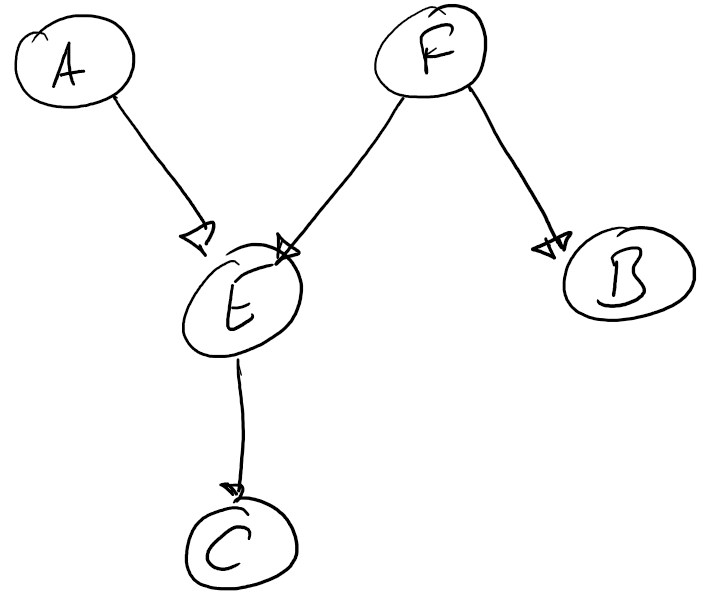

* $A \indep F | \emptyset$: path blocked at $E$
* $A \indep B | \emptyset$: path blocked at $E$
* $A \indep B | C$: $C$ is a descendant of $E$, so we know something about $E$ which makes $A$ and $F$ co-dependent.
...


## Inference in PGMs

In these lecture notes we will only look at exact inference algorithms, which are direct implementation of rules to manipulate probability distributions, such as variable elimination. However, please note that PGMs offer a wide range of generic inference algorithms, both exact and approximate.

We use inference to obtain the distribution of some variables of interest, conditioned on some other variables.

### Kalman Filter

For a concrete example, consider the Kalman filter, a model for localization using noisy sensors (during the exercise you have worked on a 1D variant of the Kalman filter, in these notes we will concentrate on showing you how the inference works, then I'll give you equations for the linear case with Gaussian noise assumptions). The Kalman filter works in the following way:
1. the agent maintains a belief over its initial location, which we will call $p(Z_1)$, using the symbol $Z$ to emphasize the fact that the true location is unknown and unobserved - it is a latent random variable.
2. the agent does a GPS measurement, getting a readout $X_1$. The measurement depends on the actual loaction of the agent, we model it by $p(X_1|Z_1)$.
3. Next, the agent moves to a new location, $Z_2$, which depends on its current location and which we model using $p(Z_2|Z_1)$.
4. While at $Z_2$, the agent makes another GPS measurement $X_2$.
5. The agent moves again, and does more GPS queries.

Thus the agent doesn't know its precise location, which keeps changing, and maintains a belief (probability distribution) about it, which it updates using noisy GPS measurements.

A Kalman filter has two main ways of operation:
1. Filtering: On-line position estimation, i.e. answering the question "where is the agent given past GPS measurement?", or formally computing $p(Z_t | X_1, X_2, ..., X_t)$.
2. Smoothing: Off-line position estimation, i.e. answering the question "where was the agant at time $t$ when all (past and future) GPS readouts are known", or formally computing $p(Z_t | X_1, X_2, .., X_t, ..., X_T)$

We will soon see how to answer both of these questions!

However, first, let's draw the graphical model for the Kalman filter.


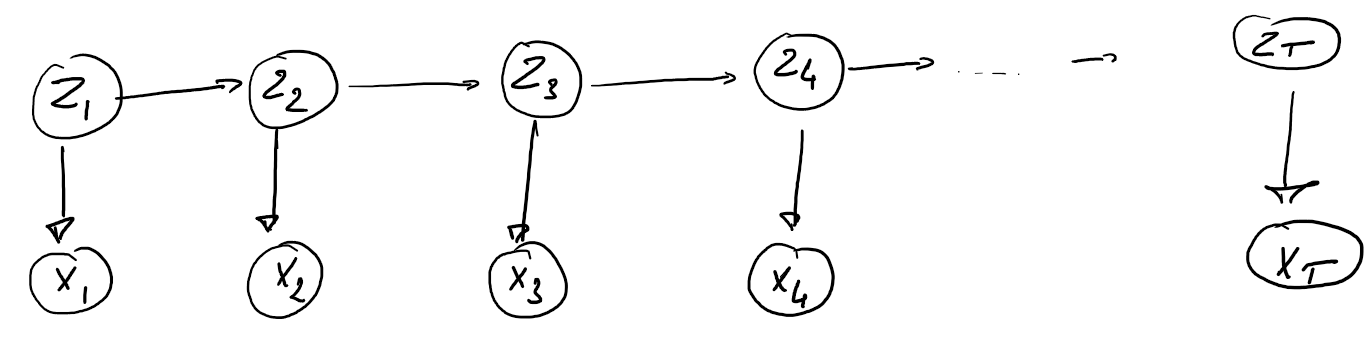

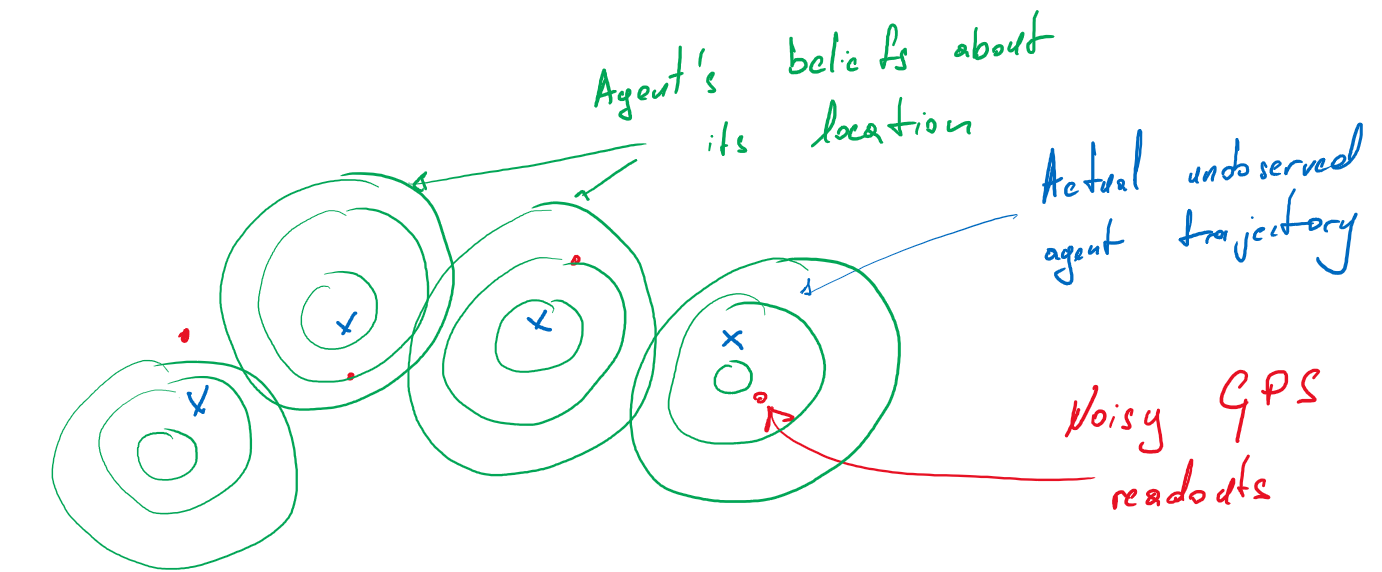

Please note how the PGM reflects the mechanics of the assumed model: the location at time $t$ only depends on the location at time $t-1$, and the GPS readouts only depend on the current location.

The model has an important property: 
$$
Z_{<t},X_{<t} \indep Z_{>t},X_{>t} | Z_t
$$
which means that the past positions of the agent (and GPS measurements) are independent from the future ones, given that we know where the agent is at time $t$! This is a very strong modeling assumption: everything the agent remembers is stored in $Z_t$, its future actions may only depend on it. For this reason, $Z_t$ is often called the _state vector_ and it often contains information on agent movement, i.e. position, velocity, acceleration.

The assumption that the agent has a state, which separates the past from the future is called the Markov assumption. It is often a good choice, though even in the simple example there are some phenomena that will be missed, for instance an ongoing estimation of GPS drift (unless it is placed into the state as well).

In general, there is a tension about keeping a small state, which makes the filtering/smoothing fast, and keeping an extensive state which carries more information about the agent's past.

#### Kalman filtering

Let's now compute how the agent may maintain an up-to-date belief about its location, by keeping a probability distribution $p(Z_{t}|X_1, X_2, ..., X_t)$.

We will assume, that the agent updates its belief once a measurement arrives. The agent has an initial belief about its location $p(Z_1|\emptyset)$.

When the first measurement $X_1$ arrives we want to compute $p(Z_1|X_1)$. We do it using the Bayes theorem:

$$
p(Z_1 | X_1) = \frac{p(X_1|Z_1)p(Z_1)}{p(X_1)} = \frac{1}{\mathcal{Z_1}} p(X_1|Z_1)p(Z_1),
$$
with $\mathcal{Z_1}$ a normalization constant.

When the second measurement arrives we first compute $p(Z_2 | X_1)$ by marginalizing over $Z_1$:
$$
p(Z_2|X_1) = \int \partial{Z_1} p(Z_1, Z_2 | X_1) = \int \partial{Z_1} p(Z_1 | X_1) p (Z_2 | Z_1, X_1) = \int \partial{Z_1} p(Z_1 | X_1) p (Z_2 | Z_1),
$$
where we have used the fact that $Z_2 \indep X_1 | Z_1$.

Then we reapply the Bayes theorem to get $p(Z2 | X_1, X_2)$:
$$
p(Z_2 | X_1,X_2) = \frac{p(X_2| Z_2, X_1)p(Z_2|X_1)}{p(X_2 | X_1)} = \frac{p(X_2| Z_2)p(Z_2|X_1)}{p(X_2|X_1)} = \frac{1}{\mathcal{Z_2}} p(X_2| Z_2)p(Z_2|X_1)
$$


Likewise, when the $t$-th measurement arrives we repeat these two steps:
1. project our belief about the location by marginalizing over $Z_{t-1}$ and computing $p(Z_t|X_1,...,X_{t-1})$.
    $$
    p(Z_{t}|X_1,...,X_{t-1}) = \int \partial{Z_{t-1}} p(Z_{t-1}, Z_{t} | X_1,...,X_{t-1}) = \int \partial{Z_{t-1}} p(Z_{t-1} | X_1,...,X_{t-1}) p (Z_t | Z_{t-1}, X_1,...,X_{t-1}) = \int \partial{Z_{t-1}} p(Z_{t-1} | X_1,...,X_{t-1}) p (Z_{t} | Z_{t-1})
    $$
2. apply the Bayes theorem to incorporate the $t$-th measurement $X_t$:
    $$
    p(Z_t | X_1,...,X_t) = \frac{p(X_t| Z_t, X_1,...,X_{t-1})p(Z_t|X_1,...,X_{t-1})}{p(X_{t} | X_1,...,X_{t-1})} = \frac{p(X_t| Z_t)p(Z_t|X_1,...,X_{t-1})}{p(X_{t} | X_1,...,X_{t-1})} = \frac{1}{\mathcal{Z_t}} p(X_t| Z_t)p(Z_t|X_1,...,X_{t-1})
    $$


The two steps can be combined into one equation:
$$
p(Z_t | X_1,...,X_t) = \frac{1}{\mathcal{Z_t}} p(X_t| Z_t) \int \partial{Z_{t-1}} p(Z_{t-1} | X_1,...,X_{t-1}) p (Z_{t} | Z_{t-1})
$$

This forward filtering scheme is so popular, that the filtered estimations are often called $\hat{\alpha}(Z_t) = p(Z_t | X_1,...,X_t)$, with:
$$
\hat{\alpha}(Z_t) = \frac{1}{\mathcal{Z_t}} p(X_t| Z_t) \int \partial{Z_{t-1}} \hat{\alpha}(Z_{t-1}) p (Z_{t} | Z_{t-1})
$$

The order of computations has a simple interpretation on the graph: we iteratively remove nodes, either using the Bayes theorem (multiply two probability distributions, then normalize by integrating over a variable and dividing) or using marginalization (integrate over a variable). This process is pictured below, where we have abused the slightly the notation to show complex probability distributions in nodes:

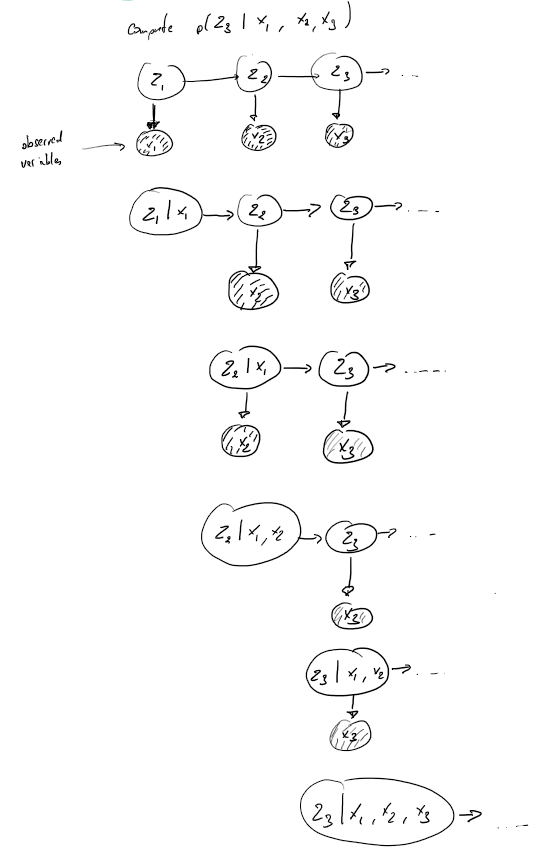

#### Kalman filtering implementation

The Kalman filter can be efficiently implemented when we assume that all conditional probability distributions in the model are multivariate normal. 

Let 
$$
p(Z_1) = \N(Z_1;A\mu_0, P_0),
$$
where $A\mu_0$ is the mean of the initial belief about the location ($A$ is the state dynamic matrix defined below) and $P_0$ is the initial covariance.

Furthermore assume the following conditional distributions:
$$
\begin{align}
p(Z_t|Z_{t-1}) &= \N(Z_t | A Z_{t-1}, \Gamma) \\
p(X_t|Z_t) &= \N(X_t | C Z_t, \Sigma)  
\end{align}
$$
where $A$ is the state evolution matrix, $\Gamma$ is the noise added to the state (which can be a true noise, or an approximation of what we don't control in the environment - e.g. the decision where to move next of the tracked agent), $C$ is the readout matrix, and $\Sigma$ is the sensor noise.

Under these assumptions the filtered predictions are also Gaussian (conditionals and marginals of a Gaussian are Gaussians), and we will parameterize them as:
$$
p(Z_t|X_1, ..., X_t) = \N(\mu_t, V_t)
$$

Below we provide, without derivation, the computations behind each step of the Kalman filering
$$
p(Z_{t}|X_1, ..., x_{t-1}) = \N(Z_{t}; A\mu_{n-1}, P_{n-1}),
$$
where $P_{n-1} = AV_{n-1}A^T + \Gamma$. Intuitively, we transform the gaussian belief about our location at time $t-1$ ($\N(\mu_t, V_t)$) by rotating it using matrix $A$ and adding noise with standard deviation $\Gamma$.

The Bayes update with the next readout data then sets:
$$
\begin{align}
\mu_t & = A\mu_{t-1} + K_t(X_t - CA\mu_{t-1}) \\
V_t &= (I - K_tC)P_{t-1}) \\
\text{where} \\
K_t &= P_{t-1}C^T(CP_{t-1}C^T+\Sigma)^{-1}
\end{align}
$$
and $K_t$ is called the _Kalman gain matrix_. Intuitively, we compute the difference about the measurement ($X_t$) and our prediction for it ($CA\mu_{t-1}$) and correct our estimation of the location by multiplying error vector  by the gain matrix. 

#### Kalman filtering example

We will now see a working example of the Kalman filter.

The state of our agent will be a 4-element vector containing:
- the $x$ coordinate
- the $y$ coordinate
- $\dot{x}$, the velocity along the $x$ axis
- $\dot{y}$, the velocity along the $y$ axis

The dynamics matrix A will compute:
- $x_{t+1} = x_t + \dot{x}_t$, our new $x$ locatoin is the old one, plus a displacement which stems from our velocity
- $y_{t+1} = y_t + \dot{y}_t$
- $\dot{x}_{t+1} = \dot{x}_t$, the velocity doesn't change deterministically (it will change due to the random component)
- $\dot{y}_{t+1} = \dot{y}_t$


The noise matrix $\Gamma$ will be diagonal, with the (somewhat unrealistic) same standard deviation for each state component.

The readout matrix will simply return the pair $x_t, y_t$.

We will first simulate the process, then apply a filtering.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as N
import matplotlib
import matplotlib.pyplot as plt

# plotting helper
def make_ellipse(mean, cov, ax=None, **kwargs):
    """Plot an ellipse."""
    if ax is None:
        ax = plt.gca()
    kwargs.setdefault('alpha', 0.5)
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = matplotlib.patches.Ellipse(
        mean, v[0], v[1], 180 + angle, **kwargs)
    ell.set_clip_box(ax.bbox)
    ax.add_artist(ell)

In [2]:
# Our example matrix definitions

A = np.array([
    # x,  y, x., y.
    [ 1,  0,  1,  0],
    [ 0,  1,  0,  1],
    [ 0,  0,  1,  0],
    [ 0,  0,  0,  1],
])
G = np.diag([0.1, 0.1, 0.1, 0.1])

# A * mu0 = 0
# this simplifies handling the first readout
mu_0 = np.linalg.inv(A) @ np.zeros(4)  
P_0 = np.diag([1, 1, 10, 10])

C = np.array([
    # x,  y, x., y.
    [ 1,  0,  0,  0],
    [ 0,  1,  0,  0],
])
S = np.diag([1, 1])*5  # This controls the precision of the readout


(-2.940159322082615,
 21.109644240649846,
 -21.433600817109323,
 2.616202745623138)

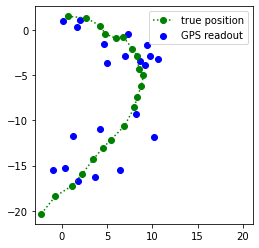

In [3]:
# A simulator

np.random.seed(42)

Zs = [N.rvs(A @ mu_0, P_0)]
Xs = [N.rvs(C @ Zs[-1], S)]

for _ in range(20):
    Zs.append(N.rvs(A @ Zs[-1], G))
    Xs.append(N.rvs(C @ Zs[-1], S))

# Now plot the data
Z_coords = np.array([z[:2] for z in Zs])
X_coords = np.array(Xs)

plt.plot(Z_coords[:, 0], Z_coords[:, 1], 'go:', label='true position')
plt.scatter(X_coords[:, 0], X_coords[:, 1], color='b', label='GPS readout')
plt.legend()
plt.axis('square')

As we can see, the GPS readouts are in the vicinity of the true (and sadly unknown) location, however there is noise.

Let's see how the Filtering works

In [4]:
# The list of means and standard deviations of p(Z_t|X<t)
Preds = [(A @ mu_0, P_0)] 
# The list of means and standard deviations of p(Z_t|X<=t)
Filtered = []

Filtered_locs = []

for X in Xs:
    mu_prev, P_prev = Preds[-1]
    K = P_prev @ C.T @ np.linalg.inv(C @ P_prev @ C.T + S)
    mu = mu_prev + K @ (X - C @ mu_prev)
    V = (np.eye(K.shape[0]) +-K @ C) @ P_prev
    Filtered.append((mu, V))
    # Save the center of the predicted Gaussian for plotting
    Filtered_locs.append(mu[:2])

    # Now compute p(Z_t+1|X<=t)
    Preds.append(
        (A @ mu, A @ V @ A.T + G))

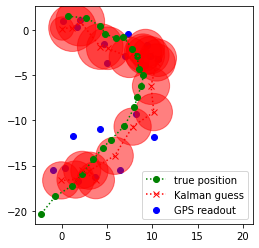

In [5]:
plt.plot(Z_coords[:, 0], Z_coords[:, 1], 'go:', label='true position')
Filtered_locs = np.array(Filtered_locs)
plt.plot(Filtered_locs[:, 0], Filtered_locs[:, 1], 'rx:', label='Kalman guess')
plt.scatter(X_coords[:, 0], X_coords[:, 1], color='b', label='GPS readout')
for mu, V in Filtered:
    make_ellipse(mu[:2], V[:2, :2], color='r')
plt.legend()
_ = plt.axis('square')

#### Kalman smoothing


Smoothing obtains more precise position estimates, because it integrates information from the past and from the future (it is an off-line algorithm).

Intuitively, to get a smoothed estimate $p(Z_t|X_1,...,X_T)$ we must reduce all nodes in the PGM: the ones relating to past readouts in the same way as we did filtering, and the future ones in a right-to-left fashion, starting from the last timestep.

$$
\begin{split}
p(Z_t|X_1,...,X_T) &= \frac{p(X_1,...,X_T|Z_t)p(Z_t)}{p(X_1,...,X_T)} = \\
&= \frac{p(X_1,...,X_{t}|Z_t)p(X_{t+1},...,X_T|Z_t)p(Z_t)}{p(X_1,...,X_T)} = \\
&= \frac{1}{\mathcal{Z}}p(Z_t|X_1, ..., X_t)p(X_{t+1},...,X_T|Z_t) = \frac{1}{\mathcal{Z}}\hat{\alpha}(Z_t)\hat{\beta}(Z_t)
\end{split}
$$

We already know how to compute $\hat{\alpha}(Z_t)=p(Z_t|X_1, ..., X_t)$ 
using the filtering procedure. A similar recurrent computation exists for 
$\hat{\beta}(Z_t)=p(X_{t+1},...,X_T|Z_t)$:

$$
\begin{split}
\hat{\beta}(Z_t)&=p(X_{t+1},...,X_T|Z_t) = \int\partial{Z_{t+1}} p(Z_{T+1}, X_{t+1},...,X_T|Z_t) = \\
&= \int\partial{Z_{t+1}} p(X_{t+1},...,X_T|Z_t, Z_{T+1}) p(Z_{T+1} | Z_T) = \\
&= \int\partial{Z_{t+1}} p(X_{t+2},...,X_T|Z_{T+1})p(X_{t+1}|Z_{T+1}) p(Z_{T+1} | Z_T) = \\
&= \int\partial{Z_{t+1}} \hat{\beta}(Z_{T+1})p(X_{t+1}|Z_{T+1}) p(Z_{T+1} | Z_T)
\end{split}
$$

### Hidden Markov Model

We will now briefly present a model very similar to the Kalman filter: the Hidden Markov Model (HMM).

Again, we will have a sequence of latent (hidden, unobserved) variables $Z_t$ which this time will be discrete: $\forall_t Z_t\in\{1, 2, ..., K\}$. The hidden state evolves using an often tabulated conditional probability distribution $p(Z_t = j | Z_{t-1}=i) = A_{ij}$ encoded using a matrix $A$ of state-transition probabilities.

HMMs often arise in speech processing, and are the workhorse of the classical speech recognition (in fact, a popular neural approach to speech recognition called CTC can also be pictured as an HMM!).

In speech we assume that the hidden states are the unknown sequences of phonemes (basic units of sound): the sequence of phonemes evolves using rules for words, 




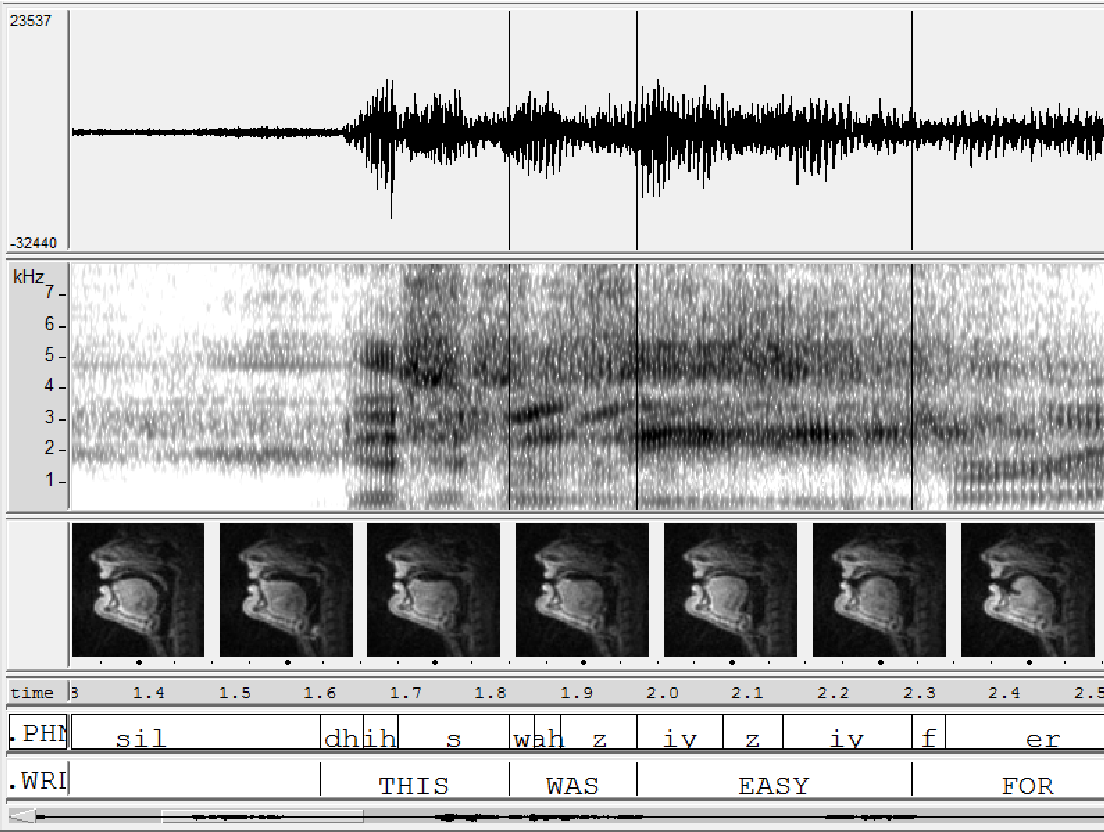
The [MRI_TIMIT](https://sail.usc.edu/span/mri-timit/) corpus contains MRI images of the speech apparatus aligned with speech. We can model the dynamic behavior of the system by assuming that at each moment one of a set of phonemes is uttered, and the position of the vocal apparatus, as well as the uttered souds depend on the phoneme being uttered. The time-aligned sequence of phonemes can be interpreted as a sequence of latent variables with known dynamic (the phoneme at time $t+1$ is either a repetition of the phoneme at time $t$, or the next phoneme in the sentence)

The emission probability can be any parameteric probability distribution, however it is often a Gaussian mixture: each hidden state results in the observation sampled from a Gaussian with state-dependent mean and covariance.

Thus a typical HMM model is defined by:
$$
\begin{align}
p(Z_1=k) &= \pi_{k} \\
p(Z_t = j | Z_{t-1}=i) &= A_{ij} \\
p(X_t|Z_t=k) &= \N(\mu_k, \Sigma_k)
\end{align}
$$

It can be pictured as a PGM with the same structure as the Kalman filter! This happens because the dependency structure is exactly the same. 

The set of tasks we solve using HMMs is also similar to the Kalman filter. We are often interested in:
- filtering, i.e. computing $p(Z_t|X_1, ..., X_t)$,
- smoothing, i.e. computing $p(Z_t|X_1, ..., X_T)$,
- decoding, i.e. finding the most probable sequence of laent states $max_{Z_1,...,Z_T}p(Z_1, ..., Z_T | X_1, ..., X_T)$.

#### Inference in HMMs

Inference in HMMs follows the very same pattern as in the case of the Kalman filter: we maintain a belief over the probability distribution over the state at time $t$ and compute it recursively.

Define $\alpha{Z_t} = p(Z_t, X_1, ..., X_t)$. Then we can derive, in a manner similar to the Kalman filter the recurrent relation:
$$
p(Z_t, X_1, ..., X_t) = \alpha{Z_t} = p(X_t|Z_t)\sum_{Z_{t-1}}\alpha(Z_{t-1})p(Z_t|Z_{t-1}
$$

Please note, that we chose to define $\alpha$ for HMMs as a joint, rather than conditional probability (compare with $\hat\alpha$ for the Kalman filter) for ease of manipulation: in the case of th eKalman filter, we wanted to maintain Gaussian distributions. For HMMs, we will tabulate the values for each possible discrete state.

Likewise, we can compute the backward recurrence for $\beta(Z_t)$:

$$
p(X_{t+1}, ..., X_T | Z_T) =  \beta(Z_t) = \sum_{Z_{t+1}} \beta(Z_{t+1})p(X_{t+1}|Z_{t+1})p(Z_{t+1}|Z_{t})
$$

with the starting condition $\beta(Z_T=k)=1\forall k$.

The values of $\alpha$ and $\beta$ allow the computation of smoothed state estimations:

$$
p(Z_t|X_1,...,X_T) = \frac{p(X_1,...,X_T|Z_t)p(Z_t)}{p(X_1,...,X_T)} = \frac{p(X_1,...,X_t|Z_t)p(Z_t)p(X_{t+1},...,X_T|Z_t)}{p(X_1,...,X_T)} = \frac{\alpha(Z_t)\beta(Z_t)}{p(X_1,...,X_T)}
$$
where we have used the independence of $X_{\leq t}$ and $X_{>t}$ given $Z_t$. Finally it is easy to show that:
$$
p(X_1,...,X_T) = \sum_{Z_t} \alpha(Z_t)\beta(Z_t)\qquad \forall Z_t.
$$

#### Another view on $\alpha(Z_t)$: sums over paths

We can obtain further insights about the recurrent computation for $\alpha$ by considering the picture below (nb. it is NOT a PGM), in which each square represents the value of $\alpha(Z_t=k)$. The columns of nodes between two neighboring timesteps are connected with edges, whose weighs are given by the entries of the matrix $A$. As seen in the picture, the computation of $\alpha(Z_2=1)$ involves the summation over all edges that reach the node $Z_2=1$.

This uncovers a connection between path-finding algorithms on graphs and inference in HMMs.

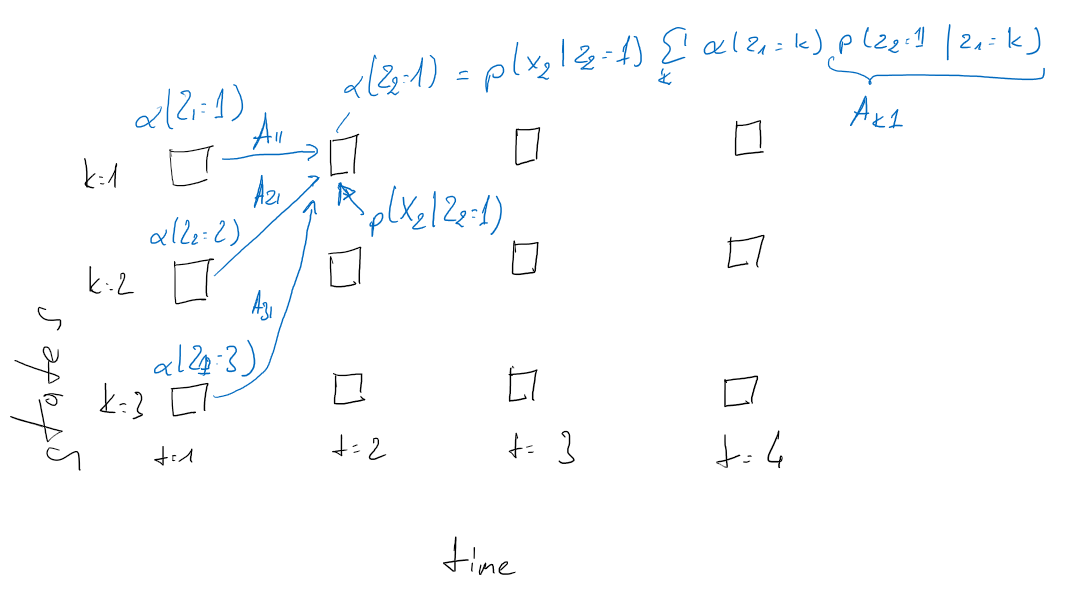

Consider the graph below in which again nodes correspond to observing a state $k$ at time $t$. Any path $\rho$ through that graph is a sequence of state numbers: $\rho\in\{1,...,K\}^T$. The probability of observing the sequence of states given by $\rho$ conditioned on the observations:

$$
p(\rho, X_1,...,X_T) = p(Z_1 = \rho_1)\left[\prod_{t=2}^T p(Z_t=\rho_t|Z_{t-1}=\rho_{t-1})\right]\left[\prod_{t=1}^T p(X_t|Z_{t-1}=\rho_{t-1})\right]
$$

To compute the probability of some observations $X_1, ..., X_T$ we must sum over all possible paths:

$$
p(X_1,...,X_T) = \sum_\rho p(\rho, X_1,...,X_T)
$$

In fact, this is precisely what the computation of $\alpha$'s is doing: intuitively, it can be interpreted as a dynamic algorithm that computes the summation over all the paths by considering partial paths which end at $Z_t=k$!

#### Decoding in HMMs == shortest paths

The graph  interpretation will also yield an efficient algorithm for finding the most probable sequence of states for observations $X_1,..., X_k$. Simply observe, that we want to find the path $\rho$ which maximizes $p(\rho, X_1,...,X_T)$! If we apply $-\log(\cdot)$ to the path probability we obtain:

$$
-\log p(\rho, X_1,...,X_T) = -\log p(Z_1 = \rho_1) + \left[\sum_{t=2}^T -\log p(Z_t=\rho_t|Z_{t-1}=\rho_{t-1})\right] + \left[\sum_{t=1}^T -\log p(X_t|Z_{t-1}=\rho_{t-1})\right]
$$

finding this $\rho$ is equivalent to finding the shortest path in the graph shown below (its nodes correspond to observing states $Z_t=k$ followed by emissions):

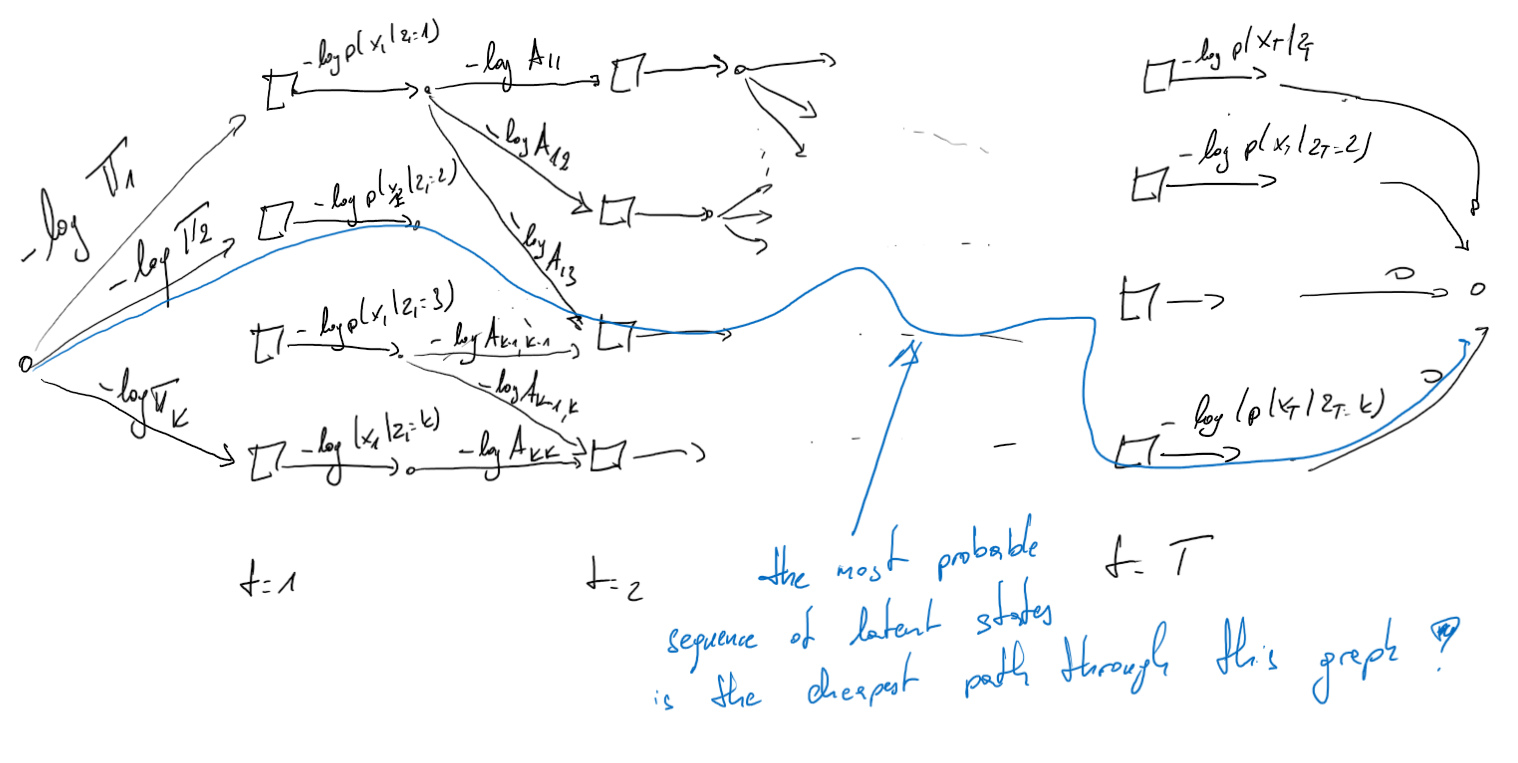

We could thus decode (i.e. find the most probeble sequence of states) in an HMM by constructing this graph and running the Dijkstra algorithm. However, we can exploit the special structure of theis graph: edges only occur between neighboring timesteps. A specialized Dijkstra search over this graph is called the Viterbi algorithm.

In [6]:
#@title HMM Demo

# Build a small HMM

# Number of hidden states
K = 3
# x's dimensionality
D = 2


np.random.seed(42)
# Transition matrix
A = np.diag([1, 1, 2]) + np.random.rand(K, K).T * 0.15
A /= A.sum(1, keepdims=True) # Aij = p(zn = j | zn-1 = i)

# Emission probs:
mus = np.random.laplace(size=(K, D)) * 3
sigmas = np.random.rand(K, D, D) * 2
# make sigmas symmetric, positive definite
for k in range(K):
    sigmas[k] = sigmas[k] @ sigmas[k].T + 2.5 * np.eye(D)

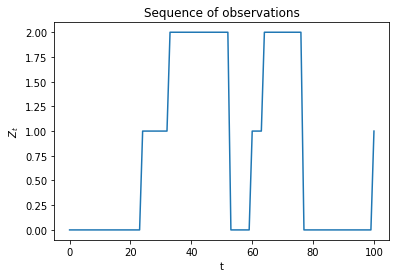

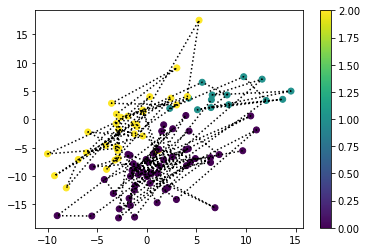

In [7]:
# Draw a sequences of Z

Zs = [0] # always start in state 0
Xs = [mus[Zs[-1]] + np.random.randn(D) @ sigmas[Zs[-1]]]
for _ in range(100):
    z = np.random.choice([0, 1, 2], 1, p=A[Zs[-1], :])[0]
    Zs.append(z)
    x = mus[Zs[-1]] + np.random.randn(D) @ sigmas[Zs[-1]]
    Xs.append(x)

Zs = np.array(Zs)
Xs = np.array(Xs)


plt.title('Hidden states $Z_t$')
plt.plot(Zs)
plt.xlabel('t')
plt.ylabel('$Z_t$')

plt.title('Sequence of observations')
plt.figure()
plt.scatter(Xs[:, 0], Xs[:,1], c=Zs)
plt.plot(Xs[:, 0], Xs[:,1], ':k')
plt.colorbar()

As we can see, the HMM makes 7 state transitions: 
- 0->1, 
- 1->2, 
- 2->0, 
- 0->1, 
- 1->2, 
- 2->0, 
- 0->1.

Readouts from a state are sampled from a normal distribution. However, the supports of distributions of observations from the 3 states overlap. 

Simple predictions of the state for made for each observation ignoring the time and state change dynamics have many 'spikes': points that while generated from state $i$, have a higher likelihood of being generated from state 'j'.

We will try to clean these spikes by using the HMM to consider the measuerments in time, and to make state transitions less probable.

In [8]:
# tabulate p(X_t | Z_t=k)
p_x_given_z = np.zeros((K, len(Zs)))
for k in range(K):
    p_x_given_z[k, :] = N.pdf(Xs, mus[k], sigmas[k])

# tabulate p(Z_t=k | X_t)
p_z_given_x = p_x_given_z / p_x_given_z.sum(0, keepdims=True)

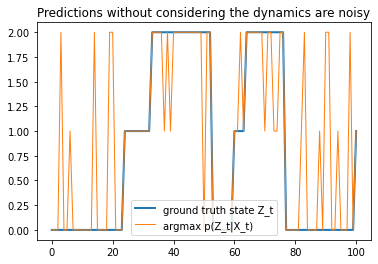

In [9]:
plt.title('Predictions without considering the dynamics are noisy')
plt.plot(Zs, linewidth=2, label='ground truth state Z_t')
plt.plot(np.argmax(p_z_given_x, 0), linewidth=1, label='argmax p(Z_t|X_t)')
plt.legend(loc='lower center')

In [10]:
alphas = np.zeros((K, len(Zs)))
# alpha(Z_0=i) = pi_i p(x_0|z_0=i)
# in our case, pi_0=1 and pi_1=pi_2=0
alphas[:, 0] = [1 * p_x_given_z[0,0], 0, 0]

for t in range(1, len(Zs)):
    for k in range(K):
        # Please note that here we should really employ log-probabilities, and 
        # change the sum-of-products reduction to a log-sum-exp one!
        alphas[k, t] = p_x_given_z[k, t] * (alphas[:, t-1] @ A[:, k])

betas = np.zeros((K, len(Zs)))
betas[:, -1] = 1.0
for t in range(len(Zs)-1 , 0, -1):
    for k in range(K):
        # similarly to computation of alphas, better numerical stability is obtained
        #when working with log-probabilities.
        betas[k, t - 1] =  betas[:, t] @ (p_x_given_z[:, t] * A[k, :])

pX = (alphas*betas).sum(0)
if (pX.max() - pX.min()) > 1e-8:
    print("Numerical instability")
pX = np.median(pX)
p_hmm_z_given_x = alphas*betas / pX

In [11]:
# Now compute the Viterbi decoding, i.e. the single most probable
# _sequence_ of states

path_costs = np.zeros((K, len(Zs)))
# initialize path costs to start with state 0
path_costs[:, 0] = [0, np.inf, np.inf]
predecessors = np.zeros((K, len(Zs)), dtype='int')

lA = -np.log(A)

# Please note the similarity between the forward computation of alphas and
# Viterbi decoding.
#
# In fact, if we chose to compute log(alpha) (which is advisable anyway due to
# better numerical stability), the only difference is that in Viterbi we 
# reduce the sequence of costs using min operator,
# while in the alpha computation this is the log-sum-exp operation
#
for t in range(1, len(Zs)):
    for k in range(K):
        costs = path_costs[:, t-1] + lA[:, k]
        predecessors[k, t] = np.argmin(costs)
        path_costs[k, t] = -np.log(p_x_given_z[k, t]) + costs[predecessors[k, t]]

decoded = np.zeros((len(Zs), ), dtype='int')
decoded[-1] = np.argmin(path_costs[:, -1])
for t in range(len(Zs)-1, 0, -1):
    decoded[t-1] = predecessors[decoded[t], t]

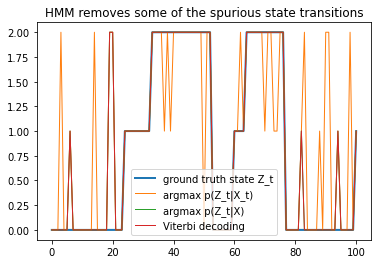

In [12]:
plt.title('HMM removes some of the spurious state transitions')
plt.plot(Zs, linewidth=2, label='ground truth state Z_t')
plt.plot(np.argmax(p_z_given_x, 0), linewidth=1, label='argmax p(Z_t|X_t)')
plt.plot(np.argmax(p_hmm_z_given_x, 0), linewidth=1, label='argmax p(Z_t|X)')
plt.plot(decoded, linewidth=1, label='Viterbi decoding')
plt.legend(loc='lower center')

In this example we can see that Viterbi decoding yielded the same sequence of states, as taking the most probable assignment at each time step. This however need not be the case.

## Fitting PGMs to data

To end this set of notes, we observe that PGMs can be fitted to data using the maximum likelihood principle:
- If all variables are observed, we simply estimate the conditional probabilities that define each node.
- If some variables are latent (e.g. we want to learn an HMM, or fit the dynamics of a Kalman filter), we can employ the EM approach: using inference, we compute the distribution over the latent variables $Z$ using inference techniques, then we maximize the parameters of the model to our predictions of $Z$.

For instance, to fit an HMM in the **E**-step we compute:
- $p(Z_1|X)$, which we then use to estimate the parameters $\pi$,
- $p(Z_t|X)$, which we then use to estimate the emission models,
- $p(Z_{t-1}, Z_t|X)$, which we then use to estimate the probabilities of state transitions.

We have already derived formulas to compute the first two quantitites. Computing $p(Z_{t-1}, Z_t|X)$ can also be expressed using the $\alpha$'s and $\beta$'s: $p(Z_{t-1}, Z_t|X)=\frac{\alpha(Z_{t-1})p(X_t|Z_t)p(Z_t|Z_{t-1})\beta(Z_t)}{p(X)}$.

We then use the gathered statistics to fit new model parameters during the **M**-step:
- $\pi_k \gets p(Z_1=k|X)$
- $A_{ij} \gets \frac{\sum_{t=2}^T p(Z_{t-1}=i, Z_t=j|X)}{\sum_{t=2}^T\sum_{k=1}^K p(Z_{t-1}=i, Z_t=k|X)}$
- params of $p(X_t|Z_t)$ set using maximum log-lilelihood.

## Conclusions

In this set of lecture-notes we have seen a brief introduction to representing probability distributions using graphs. This view of probability distributions has allowed us to:
- visually express the conditional dependencies in the data
- reason about independencies by analyzing paths linking nodes in the graph
- perform inference by marginalizing over variables.

We have then analyzed two concrete examples of models with latent variables: the Kalman filter and the HMM. Both of these models assume a latend dynamical system whose behavior we can indirectly observe:
- in the Kalman filter the dynamics are linear, and we observe noisy linear projections of the state
- in the HMM the state is discrete and the oservations are often modeled using a mixture model. HMMs are popular in speech processing, in which the hidden state sequence is often related to the uttered phonemes.

